In [152]:
from __future__ import print_function, division
import os
import torch
import pandas as pd     
from skimage import io, transform
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
import import_ipynb

In [154]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [155]:
path = "./dog_cats_sample.csv"
valid_path = "./dog_cats_sample_valid.csv"
data = pd.read_csv(path)

n = 6
img_name = data.iloc[n, 0]
img_labels = data.iloc[n, 1]
print(img_name)
# print(img_landmarks)

.\dog_cats\sample\Cat\1.jpg


In [156]:
class DogCats_Dataset(Dataset):
    
    def __init__(self, csv, transform=None):
        self.dog_cats_df = pd.read_csv(csv)
        self.transform = transform

    def __len__(self):
        return len(self.dog_cats_df)
    
    def __getitem__(self, index):
        image_path = self.dog_cats_df.iloc[index, 0]
        image = cv2.imread(image_path)
        image = cv2.resize(image, (244, 244))
        label = self.dog_cats_df.iloc[index, 1]
        
        if label == 'Dog':
            label = 0
        
        if label == 'Cat':
            label = 1
        
        sample = {'image' : image, 'label' : label }
        
        if self.transform:
            sample = self.transform(sample)
            return sample
        
        
        sample['image'] = image.transpose((2, 0, 1))
        sample['image'] = torch.from_numpy(sample['image'])
        sample['label'] = np.array([sample['label']])
        sample['label'] = torch.from_numpy(sample['label'])
        
        return sample

In [157]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively 

        return {'image': img, 'label': sample['label'] }


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'label': sample['label']}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        label = np.array(sample['label'])

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label) }

In [158]:
transformed_data_sets = DogCats_Dataset(path, transform=transforms.Compose([
#                                                Rescale(256),
                                               ToTensor()
                                           ]))
# valid_data_sets = DogCats_Dataset(valid_path, transform=transforms.Compose([
#                                                Rescale(256),
#                                                ToTensor()
#                                            ]))
train_data_sets = DogCats_Dataset(path)


In [159]:
train_data_loader = DataLoader(train_data_sets, batch_size=2, shuffle=True)
transformed_data_loader = DataLoader(transformed_data_sets, batch_size=2, shuffle=True)
# valid_data_loader = DataLoader(valid_data_sets, batch_size=5, shuffle=True)

In [160]:
def show_image(image, label):
    plt.imshow(image);
    plt.suptitle(image.shape, fontsize=20)
    plt.show()

In [161]:
for inputs in train_data_loader:
    print((inputs['image'].shape))

torch.Size([2, 3, 244, 244])
torch.Size([2, 3, 244, 244])
torch.Size([2, 3, 244, 244])
torch.Size([2, 3, 244, 244])
torch.Size([2, 3, 244, 244])


In [162]:
for inputs in transformed_data_loader:
    print((inputs['image'].shape),inputs['label'])
    print(len(inputs['label']))

torch.Size([2, 3, 244, 244]) tensor([1, 1], dtype=torch.int32)
2
torch.Size([2, 3, 244, 244]) tensor([0, 0], dtype=torch.int32)
2
torch.Size([2, 3, 244, 244]) tensor([0, 1], dtype=torch.int32)
2
torch.Size([2, 3, 244, 244]) tensor([1, 0], dtype=torch.int32)
2
torch.Size([2, 3, 244, 244]) tensor([1, 0], dtype=torch.int32)
2


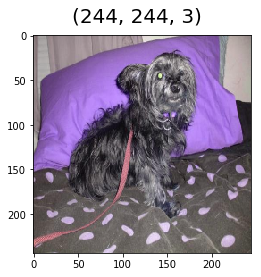

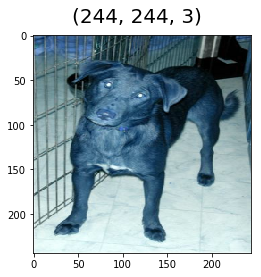

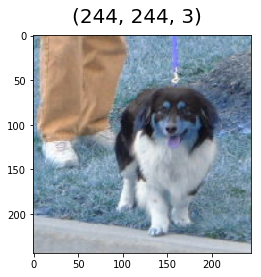

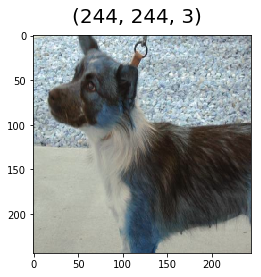

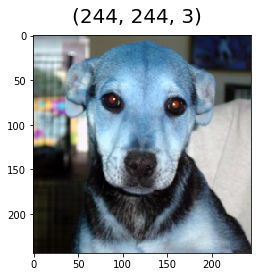

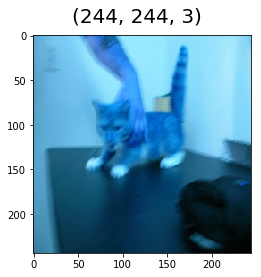

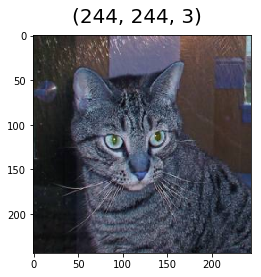

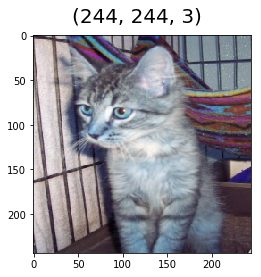

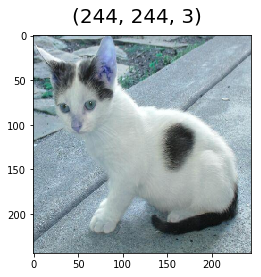

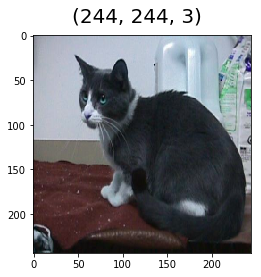

In [163]:
for i in range(len(train_data_sets)):
    im = train_data_sets[i]['image'].numpy()
    im = im.transpose((1, 2, 0))
    show_image(im, train_data_sets[i]['label'])


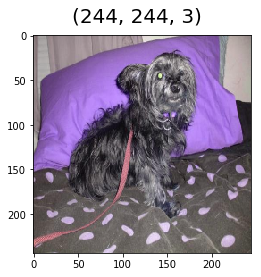

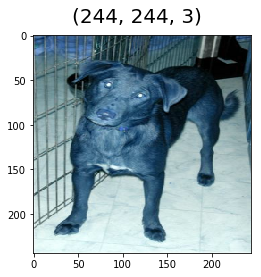

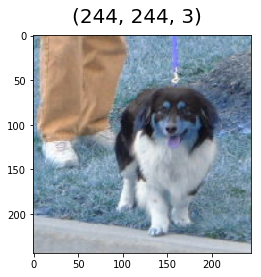

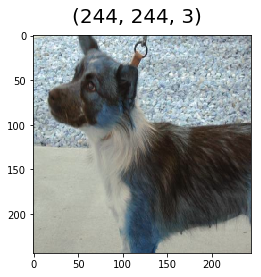

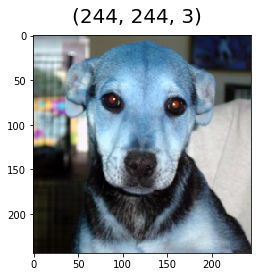

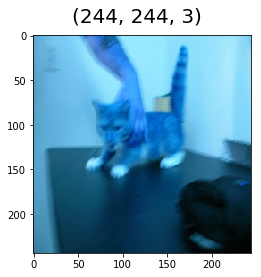

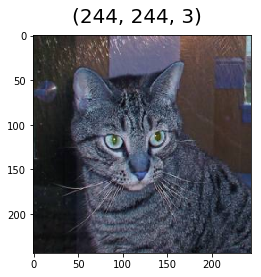

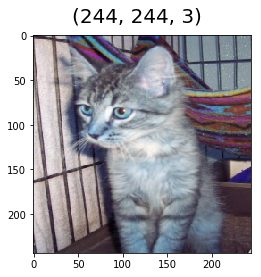

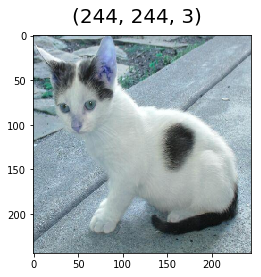

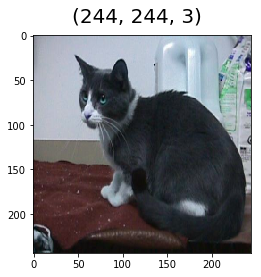

In [164]:
for i in range(len(transformed_data_sets)):
    im = transformed_data_sets[i]['image'].numpy()
    im = im.transpose((1, 2, 0))
    show_image(im, transformed_data_sets[i]['label'])
#     print(transformed_data_sets[i]['image'].transpose())

In [165]:
def im_convert(image):
    image = image.numpy()
    image = image.transpose(1,2,0)
    
    return image
# for data in train_data_loader.dataset:
#     print(data['label'])

In [166]:
# data_iter = iter(train_data_loader)
# for i in range(len(train_data_loader)):
#     data = data_iter.next()
#     print(len(data['image']))
#     for j in range(2):
        
#         if i==(len(train_data_loader) - 1) and j==len(data['image']):
#             break
            
#         print(i, j)
#         img = im_convert(data['image'][j])       
#         plt.imshow(img)
#         plt.show()

for inputs in train_data_loader:
    label = inputs['label']
    print(inputs['image'].shape)
    print(label.shape)
        
        

torch.Size([2, 3, 244, 244])
torch.Size([2, 1])
torch.Size([2, 3, 244, 244])
torch.Size([2, 1])
torch.Size([2, 3, 244, 244])
torch.Size([2, 1])
torch.Size([2, 3, 244, 244])
torch.Size([2, 1])
torch.Size([2, 3, 244, 244])
torch.Size([2, 1])


In [167]:
class Vgg_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = relu_max_pool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = relu_max_pool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = relu_max_pool(out)
        out = self.conv8(out)
        out = self.conv9(out)
        out = self.conv10(out)
        out = relu_max_pool(out)
        out = self.conv11(out)
        out = self.conv12(out)
        out = self.conv13(out)
        out = out.view(x.size(0), -1)
        out = self.classifier(out)
        return out
        
        
    def relu_max_pool(self, out):
        x = F.relu(out)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        return x 
        

In [168]:
model = Vgg_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [169]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    for inputs in train_data_loader:
        inputs = inputs['image'].to(device)
#         labels = inputs['label']
        outputs = model(inputs)
        loss = criterion(outputs, inputs['label'].to(device))
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_inputs in valid_data_loader:
                val_inputs = val_inputs['image']
                val_labels = val_inputs['label']
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
      
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
    
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

RuntimeError: _thnn_conv2d_forward not supported on CPUType for Byte